### Title

In [3]:
print(np.sin(2*np.pi*1.027777))
print(np.sin(2*np.pi*0.027777))

0.1736433649862756
0.17364336498627583


Images sets 2.1 and 2.2 precipitate the question, does ukcp18 predict more extreme FWI ratings? (The obvious conclusion being that if it does not, I have gone wrong somewhere in my code)

In [1]:
import scipy.stats
import math
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings

In [21]:
def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')

    # Getting file strings:
        # Directories:
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]

        # Filenames:
    #feat. clunky for loops and error handling!
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))

        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))


    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    
    return directories,tas_files,hurs_files,wind_files,pr_files

###### UKCP

In [30]:
tag = ['01','04','05','06','07','08','09','10','11','12','13','15']
ukcp_fwi = np.zeros(80)
length_uk = 0

for i in range(len(tag)):
    print(f'Step {i+1} of {len(tag)}')
    
    region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
    region_mask = region_data.admin_region
    region_mask = np.nan_to_num(region_mask)
    mask = (region_mask == 0).astype(int)
    
    tas_file = f'/data/met/ukcp18/{tag[i]}/dmo/tas_rcp85_ukcp18_natgb_{tag[i]}_day_19801201-20801130.nc'
    tas_data  = xarray.open_dataset(tas_file, engine = "netcdf4")

    try:
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    del tas_file,tas_data
    summer_inds=np.concatenate((np.where(months == 6)[0],np.where(months == 7)[0],np.where(months == 8)[0]),axis = 0)
    del months
    
    fwi = np.load(f'/data/met/fwi/ukcp18_new_fwi_{tag[i]}.npy')[:,summer_inds,:,:]
    fwi = np.einsum('ijkl,kl->ijkl',fwi,np.logical_not(mask)).flatten()
    length_uk = length_uk + np.sum(np.logical_not(mask))*fwi.shape[0]/(128*108)
    hist, bin_edges = np.histogram(fwi, bins=80, range=(0,120))
    ukcp_fwi = ukcp_fwi + hist
    del fwi,summer_inds, hist
print(ukcp_fwi.shape)
print(length_uk)

Step 1 of 12
Step 2 of 12
Step 3 of 12
Step 4 of 12
Step 5 of 12
Step 6 of 12
Step 7 of 12
Step 8 of 12
Step 9 of 12
Step 10 of 12
Step 11 of 12
Step 12 of 12
(80,)
179172000.0


###### CORDEX

In [31]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
cordex_fwi = np.zeros(80)
length = 0

for i in range(2,50):
    print(f'Step {i-1} of {len(directories)-1}')
    
    region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
    region_mask = region_data.admin_region
    region_mask = np.nan_to_num(region_mask)
    mask = (region_mask == 0).astype(int)
    
    tas_data  = xarray.open_dataset(directories[i-1] + tas_files[i-1], engine = "netcdf4")
    try:
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    del tas_data
    summer_inds=np.concatenate((np.where(months == 6)[0],np.where(months == 7)[0],np.where(months == 8)[0]),axis = 0)
    del months
    
    fwi = np.load(f'/data/met/fwi/ukcordex_new_fwi_{i}.npy')[:,summer_inds,:,:]
    fwi = np.einsum('ijkl,kl->ijkl',fwi,np.logical_not(mask)).flatten()
    length = length + np.sum(np.logical_not(mask))*fwi.shape[0]/(128*108)
    
    hist, bin_edges = np.histogram(fwi, bins=80, range=(0,120))
    cordex_fwi = cordex_fwi + hist
    del fwi,summer_inds, hist
print(cordex_fwi.shape)

<class 'list'>
Step 1 of 48
Step 2 of 48
Step 3 of 48
Step 4 of 48
Step 5 of 48
Step 6 of 48
Step 7 of 48
Step 8 of 48
Step 9 of 48
Step 10 of 48
Step 11 of 48
Step 12 of 48
Step 13 of 48
Step 14 of 48
Step 15 of 48
Step 16 of 48
Step 17 of 48
Step 18 of 48
Step 19 of 48
Step 20 of 48
Step 21 of 48
Step 22 of 48
Step 23 of 48
Step 24 of 48
Step 25 of 48
Step 26 of 48
Step 27 of 48
Step 28 of 48
Step 29 of 48
Step 30 of 48
Step 31 of 48
Step 32 of 48
Step 33 of 48
Step 34 of 48
Step 35 of 48
Step 36 of 48
Step 37 of 48
Step 38 of 48
Step 39 of 48
Step 40 of 48
Step 41 of 48
Step 42 of 48
Step 43 of 48
Step 44 of 48
Step 45 of 48
Step 46 of 48
Step 47 of 48
Step 48 of 48
(80,)


In [32]:
print(length)
print(length_uk)

730955400.0
179172000.0


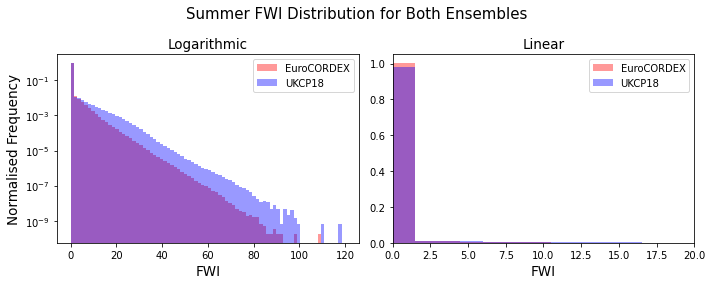

In [43]:
plt.rcParams["figure.figsize"] = (10,4)
fig,ax = plt.subplots(1,2)

width = 1 * (bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:]) / 2

weights = np.ones_like(cordex_fwi)/(length*8)
ax[0].set_yscale('log')
ax[0].bar(center, cordex_fwi*weights, align='center', width=width, alpha=0.4,color='red')
ax[1].set_yscale('linear')
ax[1].bar(center, cordex_fwi*weights, align='center', width=width, alpha=0.4,color='red')

weights = np.ones_like(ukcp_fwi)/(length_uk*8)
ax[0].set_yscale('log')
ax[0].bar(center, ukcp_fwi*weights, align='center', width=width, alpha=0.4,color='blue')
ax[1].set_yscale('linear')
ax[1].bar(center, ukcp_fwi*weights, align='center', width=width, alpha=0.4,color='blue')

ax[0].set_ylabel('Normalised Frequency',fontsize=13.5)
ax[0].set_xlabel('FWI',fontsize=13.5)
ax[0].set_title('Logarithmic',fontsize=13.5)
ax[1].set_title('Linear',fontsize=13.5)
ax[1].set_xlabel('FWI',fontsize=13.5)
ax[1].set_xlim((0,20))

fig.suptitle('Summer FWI Distribution for Both Ensembles',fontsize=15)
ax[0].legend(('EuroCORDEX','UKCP18'))
ax[1].legend(('EuroCORDEX','UKCP18'))


plt.tight_layout()
plt.savefig('/home/theo/final_images/2.3.images/fwi_distribution_comparison')


#### Checking FWI inputs:

In [34]:
i = 2
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

tas_data  = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
hurs_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
pr_data  = xarray.open_dataset(directories[i] + pr_files[i], engine = "netcdf4")
wind_data  = xarray.open_dataset(directories[i] + wind_files[i], engine = "netcdf4")

UK_data = np.zeros((4,tas_data.tas.shape[0],128,108))

print('Data loaded...\n')

print(f'{np.min(np.array(tas_data.tas[:,:,:]) - 273.15)},{np.mean(np.array(tas_data.tas[:,:,:]) - 273.15)},{np.max(np.array(tas_data.tas[:,:,:]) - 273.15)}') #From K to C
print(f'{np.min(np.array(hurs_data.hurs[:,:,:]))},{np.mean(np.array(hurs_data.hurs[:,:,:]))},{np.max(np.array(hurs_data.hurs[:,:,:]))}')
print(f'{np.min(np.array(wind_data.sfcWind[:,:,:])*3.6)},{np.mean(np.array(wind_data.sfcWind[:,:,:])*3.6)},{np.max(np.array(wind_data.sfcWind[:,:,:])*3.6)}')
print(f'{np.min(np.array(pr_data.pr[:,:,:])*86400)},{np.mean(np.array(pr_data.pr[:,:,:])*86400)},{np.max(np.array(pr_data.pr[:,:,:])*86400)}')

<class 'list'>
Data loaded...

-23.278839111328125,10.182262420654297,31.40447998046875
7.52262020111084,78.85252380371094,100.07720184326172
0.5286490321159363,27.462799072265625,105.50051879882812
1.5045274891885434e-13,3.4682991613252394,589.960952103138


In [35]:
tags = ['01','04','05','06','07','08','09','10','11','12','13','15']
i=0
tas_data = xarray.open_dataset(f'/home/theo/data/ukcp18/tas_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')
hurs_data= xarray.open_dataset(f'/home/theo/data/ukcp18/hurs_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')
wind_data= xarray.open_dataset(f'/home/theo/data/ukcp18/sfcWind_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')
pr_data  = xarray.open_dataset(f'/home/theo/data/ukcp18/pr_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')

UK_data = np.zeros((4,36000,128,108))

print('Data loaded...\n')

print(f'{np.min(np.array(tas_data.tas[:,:,:]))},{np.mean(np.array(tas_data.tas[:,:,:]))},{np.max(np.array(tas_data.tas[:,:,:]))}') #From K to C
print(f'{np.min(np.array(hurs_data.hurs[:,:,:]))},{np.mean(np.array(hurs_data.hurs[:,:,:]))},{np.max(np.array(hurs_data.hurs[:,:,:]))}')
print(f'{np.min(np.array(wind_data.sfcWind[:,:,:])*3.6)},{np.mean(np.array(wind_data.sfcWind[:,:,:])*3.6)},{np.max(np.array(wind_data.sfcWind[:,:,:])*3.6)}')
print(f'{np.min(np.array(pr_data.pr[:,:,:]))},{np.mean(np.array(pr_data.pr[:,:,:]))},{np.max(np.array(pr_data.pr[:,:,:]))}')


Data loaded...

-23.687353134155273,11.139551162719727,38.494773864746094
13.703125,79.83837127685547,138.1796875
0.4007812440395355,27.79623794555664,101.37216186523438
0.0,3.3872854709625244,691.3892211914062
